# New In This Version

- Data Augmentation
- Problems with memory allocation due vars number
    - Taking away drop layers in Conv
    - Changing batch size from 64 to 32

# Entorno de Ejecución


---



In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Aug 27 09:50:45 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.01              Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050 Ti     On  | 00000000:01:00.0  On |                  N/A |
| N/A   29C    P8              N/A / ERR! |    113MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.3 gigabytes of available RAM

Not using a high-RAM runtime


In [1]:
import numpy as np
import os
# import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as K
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam


2023-08-27 15:06:03.728353: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Creating dataset and model

In [2]:
img_train = '/tf/train'


traindataset = K.utils.image_dataset_from_directory(img_train,
                                                    label_mode='categorical',
                                                    color_mode='grayscale',
                                                    batch_size=32,
                                                    image_size=(48,48),
                                                    seed=72,
                                                    )

img_test = '/tf/test'

testdataset = K.utils.image_dataset_from_directory(img_test,
                                                    label_mode='categorical',
                                                    color_mode='grayscale',
                                                    batch_size=32,
                                                    image_size=(48,48),
                                                    seed=72,
                                                    )


Found 28709 files belonging to 7 classes.


2023-08-27 15:06:29.840058: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-27 15:06:29.846393: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-27 15:06:29.846870: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-27 15:06:29.848492: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-27 15:06:29.848981: I tensorflow/compile

Found 7178 files belonging to 7 classes.


In [3]:
model_path = '/tf/modelv0827basic20CBep.h5'

model = Sequential()

model.add(K.layers.experimental.preprocessing.Rescaling(1./255,
                                                        input_shape=(48, 48, 1)))
model.add(K.layers.experimental.preprocessing.RandomFlip('horizontal', 0))
model.add(K.layers.experimental.preprocessing.RandomContrast([0.9, 1.1], 1))
model.add(K.layers.experimental.preprocessing.RandomRotation((-0.2, 0.3), seed=2))
model.add(Conv2D(1024, (5,5),padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
# model.add(Dropout(0.25))

model.add(Conv2D(256, (5,5), activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
# model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))


model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 48, 48, 1)         0         
                                                                 
 random_flip (RandomFlip)    (None, 48, 48, 1)         0         
                                                                 
 random_contrast (RandomCon  (None, 48, 48, 1)         0         
 trast)                                                          
                                                                 
 random_rotation (RandomRot  (None, 48, 48, 1)         0         
 ation)                                                          
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 1024)      26624     
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 1024)      0

In [4]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

best = [K.callbacks.ModelCheckpoint(model_path,
                                   save_best_only=True)
#        K.callbacks.LearningRateScheduler(scheduler)
#        K.callbacks.EarlyStopping(monitor='val_loss',
#                                 patience=5,
#                                 verbose=1)
       ]

history = model.fit(traindataset,
                    validation_data=testdataset,
                    epochs=20,
                    verbose=True,
                    callbacks=best)

Epoch 1/20


2023-08-27 15:06:46.267405: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-27 15:06:47.452513: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-08-27 15:06:48.662484: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb4cd019630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-27 15:06:48.662548: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1050 Ti, Compute Capability 6.1
2023-08-27 15:06:48.668129: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-27 15:06:48.803275: I ./tensorflow/

898/898 [==============================] - ETA: 0s - loss: 1.8118 - accuracy: 0.2484

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


898/898 [==============================] - 168s 179ms/step - loss: 1.8118 - accuracy: 0.2484 - val_loss: 1.7898 - val_accuracy: 0.2586
Epoch 2/20
898/898 [==============================] - 161s 179ms/step - loss: 1.7772 - accuracy: 0.2606 - val_loss: 1.7361 - val_accuracy: 0.2885
Epoch 3/20
898/898 [==============================] - 159s 177ms/step - loss: 1.7514 - accuracy: 0.2824 - val_loss: 1.6701 - val_accuracy: 0.3495
Epoch 4/20
898/898 [==============================] - 159s 177ms/step - loss: 1.7013 - accuracy: 0.3168 - val_loss: 1.6040 - val_accuracy: 0.3625
Epoch 5/20
898/898 [==============================] - 159s 177ms/step - loss: 1.6403 - accuracy: 0.3526 - val_loss: 1.5410 - val_accuracy: 0.4037
Epoch 6/20
898/898 [==============================] - 157s 175ms/step - loss: 1.6047 - accuracy: 0.3680 - val_loss: 1.5112 - val_accuracy: 0.4262
Epoch 7/20
898/898 [==============================] - 157s 175ms/step - loss: 1.5710 - accuracy: 0.3898 - val_loss: 1.4842 - val_accura

In [5]:
print(type(history.history))
print(history.history.keys())
largo = len(history.history['accuracy'])
largo

<class 'dict'>
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


20

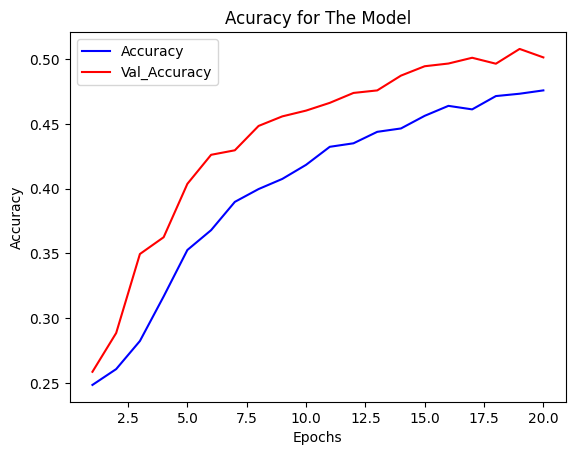

In [6]:
# Review Accuracy

plt.plot(range(1, largo + 1), history.history['accuracy'], '-b', label='Accuracy')
plt.plot(range(1, largo + 1), history.history['val_accuracy'], '-r', label='Val_Accuracy')
plt.title('Acuracy for The Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
eval = model.evaluate(testdataset, verbose=True, use_multiprocessing=True, return_dict=True)

225/225 [==============================] - 11s 46ms/step - loss: 1.3029 - accuracy: 0.5014


In [9]:
print(eval)

{'loss': 1.3029433488845825, 'accuracy': 0.5013931393623352}


In [13]:
prediction = model.predict(testdataset)

225/225 [==============================] - 9s 40ms/step


In [16]:
print(prediction)
print(prediction.shape)

[[1.24104224e-01 3.27588841e-02 1.06176794e-01 ... 3.55855703e-01
  3.38314682e-01 3.01502310e-02]
 [2.76381522e-02 1.04089770e-04 6.53362125e-02 ... 1.28539780e-03
  1.48142083e-03 9.03659701e-01]
 [9.77391452e-02 4.13699634e-03 2.69014448e-01 ... 2.46766090e-01
  2.34692127e-01 1.36569291e-01]
 ...
 [1.00680545e-01 2.60584708e-03 5.15148044e-02 ... 3.86738658e-01
  2.22863242e-01 2.33582277e-02]
 [1.08995050e-01 6.28024414e-02 2.11050302e-01 ... 1.69825569e-01
  1.89414188e-01 1.47154689e-01]
 [1.18905440e-01 9.89058893e-03 1.78710520e-01 ... 2.54772365e-01
  1.34370491e-01 2.57945508e-01]]
(7178, 7)


In [22]:
names = {k: v for v, k in enumerate(testdataset.class_names)}
print(names)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [23]:
y_true = []
y_pred = []

for x, y in testdataset:
    predictions = model.predict(x)
    
    predicted_classes = np.argmax(predictions, axis=1)
    
    true_classes = np.argmax(y.numpy(), axis=1)
    
    y_true.extend(true_classes)
    y_pred.extend(predicted_classes)


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 77ms/step


In [26]:
!pip install scikit-learn
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 5.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 9.1 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 7.4 MB/s eta 0:00:0000:01

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 1.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 14.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.3/502.3 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 19.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

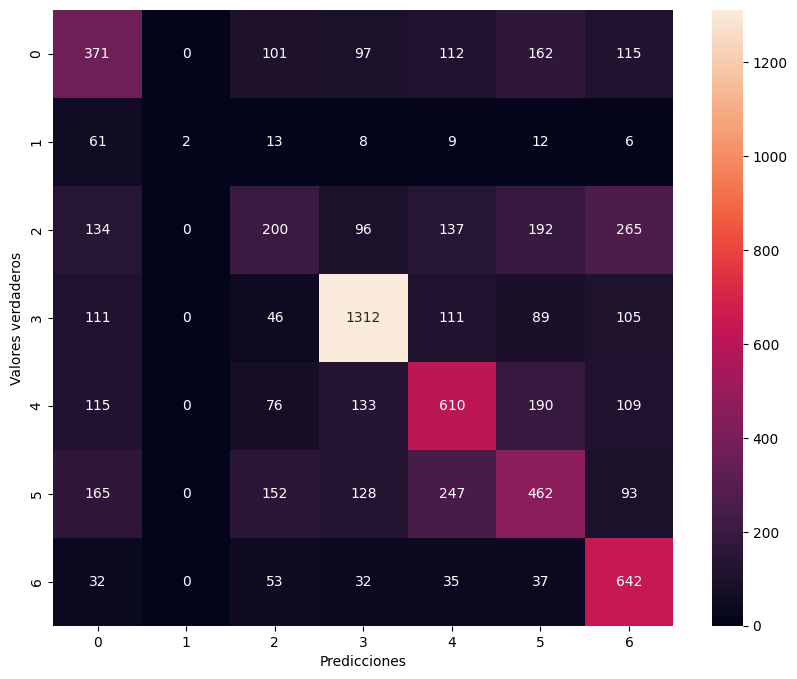

In [28]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicciones')
plt.ylabel('Valores verdaderos')
plt.show()
